In [1]:
import os
import re
import yaml
import numpy as np
import pandas as pd
import logging

from scipy import stats, signal
from pathlib import Path
from src.lib.class_load import LoadFiles
from src.data.save_models import SAVE_DIR
from src.lib.utils import select_best_model
from src.lib.factory_data import SQLDataSourceFactory, get_data, create_table, set_data
from src.lib.factory_models import ModelContext
from src.lib.factory_prepare_data import (
    DataCleaner,
    DataModel,
    MeanImputation,
    OutliersToIQRMean,
    PrepareDtypeColumns,
    base_dtypes
)
from src.models.DP_model import Modelos
from src.features.features_redis import HandleRedis
from src.features.features_postgres import HandleDBpsql
from src.models.args_data_model import Parameters
from src.data.logs import LOGS_DIR

/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [27]:
path_folder = os.path.dirname(
    '/home/bdebian/Documents/Projects/app_prediction/src')
folder_model = Path(path_folder).joinpath("scr/data/save_models")

handler_load = LoadFiles()
handler_redis = HandleRedis()
ruta_actual = os.path.dirname(
    '/home/bdebian/Documents/Projects/app_prediction/src')

# =================================================================
#             Configuracion Logger
# =================================================================
# Configura un logger personalizado en lugar de usar el logger raíz
logfile = ruta_actual + "/src/data/config/logging.conf"
logging.config.fileConfig(os.path.join(LOGS_DIR, logfile))
logger = logging.getLogger("train")
logger.debug("Inciando secuencia de entrenamiento")

# =================================================================
#             Cargar los parametros
# =================================================================
CONFIG_FILE = ruta_actual + "/src/data/config/config.yaml"
with open(CONFIG_FILE, "r", encoding="utf-8") as file:
    parameters = yaml.safe_load(file)

logger.debug("Archivo de configuraciones cargado")
parametros = Parameters(**parameters)
# =================================================================
#             Cargar datos de la fuente de datos
# =================================================================
# Interacion para hacer un cache de los datos en redis
try:
    logger.debug("verficando si existe data cache")
    data = handler_redis.get_cache_data(
        hash_name=parametros.query_template["table"],
        config=parametros.connection_data_source,
    )
    # Condicional para actualizar datos en caso de existan datos en redis
    if data is not None:
        logger.debug("Existe data en cache")

        # Secuencia de codigo para perdir nuevos datos a la base de datos
        date_col_query = parameters["query_template"]["columns"]["0"]
        LAST_DAY = str(data.iloc[-1][0])
        parameters["query_template"]["where"] = f" \"{date_col_query}\" > '{LAST_DAY}'"
        parameters["query_template"]["order"] = "".join(
            ['"' + columna + '"' for columna in [date_col_query]])

        logger.debug("Realizando peticion a la fuente de datos")

        # Extraccion de la nueva data para actualizar
        new = get_data(SQLDataSourceFactory(**parameters))
        logger.debug("Actualizando cache en redis")
        data = handler_redis.set_cache_data(
            hash_name=parametros.query_template["table"],
            old_dataframe=data,
            new_dataframe=new,
            exp_time=parametros.exp_time_cache,
            config=parametros.connection_data_source,
        )
        logger.debug("Actualizacion completa de datos en redis")

    # Verificar que existieran datos en cache
    if data is None:
        logger.debug("No existe cache de datos")

        data = get_data(SQLDataSourceFactory(**parameters))
        logger.debug("Insertando datos de cache en redis")
        data = handler_redis.set_cache_data(
            hash_name=parametros.query_template["table"],
            old_dataframe=data,
            new_dataframe=None,
            exp_time=parametros.exp_time_cache,
            config=parametros.connection_data_source,
        )

except ValueError as error:
    logger.debug("[ERROR] No se puede hacer un cache de la fuente de datos")
    logger.debug(error)
    exit()

2024-04-15 14:53:58,278 - train - DEBUG - Inciando secuencia de entrenamiento
2024-04-15 14:53:58,278 - train - DEBUG - Inciando secuencia de entrenamiento
2024-04-15 14:53:58,281 - train - DEBUG - Archivo de configuraciones cargado
2024-04-15 14:53:58,281 - train - DEBUG - Archivo de configuraciones cargado
2024-04-15 14:53:58,281 - train - DEBUG - verficando si existe data cache
2024-04-15 14:53:58,281 - train - DEBUG - verficando si existe data cache
2024-04-15 14:53:58,383 - train - DEBUG - Existe data en cache
2024-04-15 14:53:58,383 - train - DEBUG - Existe data en cache
2024-04-15 14:53:58,384 - train - DEBUG - Realizando peticion a la fuente de datos
2024-04-15 14:53:58,384 - train - DEBUG - Realizando peticion a la fuente de datos
2024-04-15 14:53:58,404 - train - DEBUG - Actualizando cache en redis
2024-04-15 14:53:58,404 - train - DEBUG - Actualizando cache en redis
2024-04-15 14:53:58,430 - datasource - DEBUG - Recuperando data existente
2024-04-15 14:53:58,430 - datasource

In [28]:
# =================================================================
#             Limpieza de datos
# =================================================================
# Nuevos datos para reemplazar en las columnas
new_types = []

for dtypo in parameters["type_data"].values():
    new_types.append(base_dtypes[dtypo])

# metodo para transformar los tipo de datos
strategy = {int: np.mean, float: np.mean, object: stats.mode}

# Estrategias para imputar los datos faltantes de NA
replace = {
    int: lambda x: int(float(x.replace(",", ""))),
    float: lambda x: float(x.replace(",", "")),
    object: lambda x: x.strip(),
}
# =================================================================

update_dtype_columns = PrepareDtypeColumns(
    replace_dtypes=new_types,
    strategy_imputation=strategy,
    preprocess_function=replace,
    **parameters,
)

# Ejecucion de fabrica para aplicar y ordenar los tipos de datos y los valores
cleaner = DataCleaner()
cleaner.strategy = update_dtype_columns
data_ = cleaner.clean(data)

# Condicion de filtrado para informacion segun los valores
filter_label: str = parameters["filter_data"]["filter_1_feature"]
filter_col: str = parameters["filter_data"]["filter_1_column"]
filter_product = data_.dataframe[filter_col] == filter_label
filter_data = data_.dataframe[filter_product].sort_values(
    by=parameters["filter_data"]["date_column"])

# Seleccion de agrupacion de tiempo
# parameters["filter_data"]["group_frequecy"] = "M"
# parameters["filter_data"]["filter_1_feature"] = filter_label

# # Datos de validacion
# validate_data = filter_data.set_index(time_series_col)["2023-12-01":].reset_index()

# # Datos de entrenamiento
# filter_data = filter_data.set_index(parameters["filter_data"]["date_column"])[
#     :"2023-11-30"].reset_index()

outliners = OutliersToIQRMean(**parameters)
cleaner.strategy = outliners
outlines_data = cleaner.clean(filter_data)
# validate_outlines = cleaner.clean(validate_data)

# Filtrado de datos para eliminar valores negativos
filter_values = outlines_data["quantity"] <= 0
outlines_data[filter_values] = 0.1
# =================================================================
#             Filtro pasabajos
# =================================================================
fs = 1 / 24 / 3600  # 1 day in Hz (sampling frequency)

nyquist = fs / 0.5  # 2 # 0.5 times the sampling frequency
cutoff = 0.5 # 0.1 fraction of nyquist frequency, here  it
# print("cutoff= ", 1 / cutoff * nyquist * 24 * 3600, " days")
# cutoff=  4.999999999999999  days
b, a = signal.butter(5, cutoff, btype="lowpass")  # low pass filter

dUfilt = signal.filtfilt(b, a, outlines_data["quantity"])
dUfilt = np.array(dUfilt)
dUfilt = dUfilt.transpose()
outlines_data["low_past"] = dUfilt

# =================================================================
#             Preparacion de datos para el modelo
# =================================================================
data_for_model = DataModel(**parameters)
cleaner.strategy = data_for_model
data_ready, scaler_data = cleaner.clean(outlines_data)

# Creacion del dataframe para del filtro pasa bajo para los datos
low_pass_data = outlines_data["low_past"]
low_pass_data = low_pass_data.to_frame()
low_pass_data.rename(columns={"low_past": "quantity"}, inplace=True)
data_ready_lp, scaler_data_lp = cleaner.clean(low_pass_data)

/home/bdebian/Documents/Projects/app_prediction/src/features/features_fix_data.py:272: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.dataframe = self.dataframe.groupby([pd.Grouper(freq=frequency_group)])[col_group].sum()


In [29]:

# =================================================================
#            Cargar modelo
# =================================================================
# Rutas de los parametros para predicciones
save_dir = Path(SAVE_DIR).joinpath(
    parameters["filter_data"]["filter_1_feature"])
models_metrics = save_dir.joinpath(
    "train_metrics").with_suffix(".json").as_posix()

MODE_USED = select_best_model(models_metrics)

scaler_name = save_dir.joinpath("scaler").with_suffix(".pkl").as_posix()
scaler_lp_name = save_dir.joinpath("scaler_lp").with_suffix(".pkl").as_posix()
last_pred = save_dir.joinpath("previus").with_suffix(".json").as_posix()
model_train = save_dir.joinpath(
    f"model_{MODE_USED}").with_suffix(".pt").as_posix()
parameters_model = save_dir.joinpath(
    f"parametros_{MODE_USED}").with_suffix(".json").as_posix()

modelo = ModelContext(model_name=MODE_USED,
                      data=data_ready,
                      split=83,
                      covarianze=data_ready_lp,
                      ** parameters
                      )

# Cargar escaler
scaler = handler_load.load_scaler(scaler_name)
scaler_lp = handler_load.load_scaler(scaler_lp_name)

# Cargar modelo para hacer las predicciones
IntModel = Modelos[MODE_USED]
trained_parameters = handler_load.json_to_dict(json_file=parameters_model)[0]
model_update_parameters = IntModel(**trained_parameters)
model_trained = model_update_parameters.load(model_train)

# Se carga el modelo , los datos de predicciones ya se cargaron previamente en ModelContext
pred_series = modelo.predict(
    model=model_trained,
    data=None,  # data_ready,
    horizont=parameters["forecast_val"],
    past_cov=None  # data_ready_lp
)

# Invertir predicciones escaler de entrenamietno
pred_scale = scaler.inverse_transform(pred_series)

# Invertir Predicciones escaler de transformacion de los datos
# pred_scale = scaler_data.inverse_transform(pred_series)

data_frame_predicciones = pred_scale.pd_dataframe()
column_field = list(data_frame_predicciones.columns)
data_frame_predicciones.reset_index(inplace=True)
data_frame_predicciones[parameters["filter_data"]
                        ["predict_column"]].clip(lower=0, inplace=True)

Modelo importado NBeatsModel


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_280445/3089033920.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ["predict_column"]].clip(lower=0, inplace=True)


In [ ]:
# ===============================================================================================
#                       PREDICCIOENS A DB PREDICCIONES
# ===============================================================================================
# TODO:
"""Esta parte tiene un ToDo importante: Tiene que ordenarse y optimizarce para se escalable
   De momento funciona de manera estatica para ciertas cosas sobre todo el tema de la escritura
   en postgres, ademas de tener codigo copiado de funciones internas ya ordenadas
"""
logger.debug("Enviando valor de las predicciones")
# Cuantificar metricas de la columan de predicciones
metric_columns_pred = data_.metrics_column(
    data_frame_predicciones[parameters["filter_data"]["predict_column"]]
)
# Seleccion de columans para generar el dataframe de salida para la base de datos
filter_temp = []
for filter_list in parameters["filter_data"]:
    if "feature" in filter_list:
        filter_temp.append(parameters["filter_data"][filter_list])

for adding_data in filter_temp:
    data_frame_predicciones[str(adding_data)] = adding_data

new_names = list(parameters["query_template_write"]["columns"].values())
rename = {x: y for x, y in zip(
    list(data_frame_predicciones.columns), new_names)}
data_frame_predicciones.rename(columns=rename, inplace=True)

# Crear tabla para guardas la informacion
create_table(SQLDataSourceFactory(**parameters))

# Ingresar los datos a la base de datos
set_data(SQLDataSourceFactory(**parameters), data_frame_predicciones)

In [30]:
# ===============================================================================================
#                             DATOS REALES MESES
# ===============================================================================================
logger.debug("Agrupando datos reales por perido de tiempo a las predicciones")
item = filter_label
logger.debug(
    "Agrupando datos reales por perido de tiempo a las predicciones para el modelo : %s",
    item,
)

date_col = parameters["filter_data"]["date_column"]
data_col = parameters["filter_data"]["predict_column"]

outlines_data.reset_index(inplace=True)
outlines_data['code'] = filter_label
outlines_data.rename({"low_past": 'filter_data'}, axis="columns", inplace=True)
outlines_data = outlines_data.round(0)


2024-04-15 14:54:18,565 - train - DEBUG - Agrupando datos reales por perido de tiempo a las predicciones
2024-04-15 14:54:18,565 - train - DEBUG - Agrupando datos reales por perido de tiempo a las predicciones
2024-04-15 14:54:18,566 - train - DEBUG - Agrupando datos reales por perido de tiempo a las predicciones para el modelo : 90000M
2024-04-15 14:54:18,566 - train - DEBUG - Agrupando datos reales por perido de tiempo a las predicciones para el modelo : 90000M


In [34]:

with open(CONFIG_FILE, "r", encoding="utf-8") as file:
    parameters = yaml.safe_load(file)

logger.debug("Archivo de configuraciones cargado")
parametros = Parameters(**parameters)

parameters["query_template_write"]["table"] = "datos_originales_agrupados"
parameters["query_template_write"]["columns"]["0"] = "date"
parameters["query_template_write"]["columns"]["1"] = "data"
parameters["query_template_write"]["columns"]["2"] = "filter_data"
parameters["query_template_write"]["columns"]["3"] = "code"
parameters["type_data_out"] = {
    "date": "date", "data": "float", "filter_data": "float", "code": "string"}

# Crear tabla para guardas la informacion
logger.debug(
    "Creando tabla agrupacion de datos reales semanales caso de ser necesario")
create_table(SQLDataSourceFactory(**parameters))

# Solicita datos anteriores para verificar la existencia de los mismos
parameters["query_template"]["table"] = "datos_originales_agrupados"
parameters["query_template"]["columns"]["0"] = "date"
parameters["query_template"]["columns"]["1"] = "data"
parameters["query_template"]["columns"]["2"] = "filter_data"
parameters["query_template"]["columns"]["3"] = "code"
parameters["type_data_out"] = {
    "date": "date", "data": "float", "filter_data": "float", "code": "string"}
# del parameters["query_template"]["columns"]["3"]
data_last = get_data(SQLDataSourceFactory(**parameters))

rename_dict = {int(key): val for key,
               val in parameters['query_template']['columns'].items()}
data_last = data_last.rename(columns=rename_dict)

data_last = data_last[data_last['code'] == filter_label]

# Condicional para verifical la ultima fecha de los datos almacenados
# En caso de estar vacio rellena con el historial de los datos por meses
if data_last.empty:
    # Ingresar los datos a la base de datos
    logger.debug(
        "agruando informacion temporal para el modelo por datos vacios: %s", item)
    print(outlines_data)
    # set_data(SQLDataSourceFactory(**parameters), outlines_data)
else:
    # obtiene el ultimo punto de las predicciones
    LAST_DATE = data_last.iloc[-1, 0]
    # Filtra los datos a enviar en base a la ultima fecha
    outlines_data = outlines_data[outlines_data[date_col]
                                  > np.datetime64(LAST_DATE)]

    # Ingresar los datos a la base de datos
    logger.debug(
        "agruando informacion temporal para el modelo por datos restantes : %s", item)
    print(outlines_data)
    # set_data(SQLDataSourceFactory(**parameters), outlines_data)

2024-04-15 14:55:23,473 - train - DEBUG - Archivo de configuraciones cargado
2024-04-15 14:55:23,473 - train - DEBUG - Archivo de configuraciones cargado
2024-04-15 14:55:23,475 - train - DEBUG - Creando tabla agrupacion de datos reales semanales caso de ser necesario
2024-04-15 14:55:23,475 - train - DEBUG - Creando tabla agrupacion de datos reales semanales caso de ser necesario
2024-04-15 14:55:23,481 - datasource - ERROR - relation "datos_originales_agrupados" already exists

2024-04-15 14:55:23,481 - datasource - ERROR - relation "datos_originales_agrupados" already exists

2024-04-15 14:55:23,481 - datasource - ERROR - relation "datos_originales_agrupados" already exists

2024-04-15 14:55:23,481 - datasource - ERROR - relation "datos_originales_agrupados" already exists

2024-04-15 14:55:23,483 - datasource - DEBUG - Finalizacion query
2024-04-15 14:55:23,483 - datasource - DEBUG - Finalizacion query
2024-04-15 14:55:23,490 - train - DEBUG - agruando informacion temporal para el 

In [32]:
outlines_data

,created_at,quantity,filter_data,code
0,2015-01-31,687343.0,687177.0,90000M
1,2015-02-28,1249163.0,1088681.0,90000M
2,2015-03-31,909375.0,1133991.0,90000M
3,2015-04-30,1174854.0,948702.0,90000M
4,2015-05-31,734887.0,905217.0,90000M
...,...,...,...,...
106,2023-11-30,1267754.0,1197053.0,90000M
107,2023-12-31,1267754.0,1311708.0,90000M
108,2024-01-31,1306800.0,1448861.0,90000M
109,2024-02-29,1446800.0,1238489.0,90000M


In [ ]:
metric_eval: dict = {}

modelos_list_used = [
    "BlockRNNModel",
    "NBeatsModel",
    "TCNModel",
    "TransformerModel",
    "TFTModel",
    "DLinealModel",
    "NLinearModel",
]

for selected_model in modelos_list_used:
    MODE_USED = selected_model
    print(f"Entrenando {selected_model}")

    modelo = ModelContext(
        model_name=MODE_USED,
        data=data_ready,
        split=80,
        covarianze=data_ready_lp,
        **parameters
    )

    # Entrenar el modelo
    model_trained = modelo.train()

    # Optimizar los parametros del modelo
    if parameters["optimize"]:
        print("Optimizando parametros del modelo")
        model_trained = modelo.optimize()

    # Guargar los modelos entrenados
    modelo.save(model_trained, scaler=scaler_data, scaler_name="scaler")
    modelo.save(None, scaler=scaler_data_lp, scaler_name="scaler_lp")

    print("metodo finalizado")

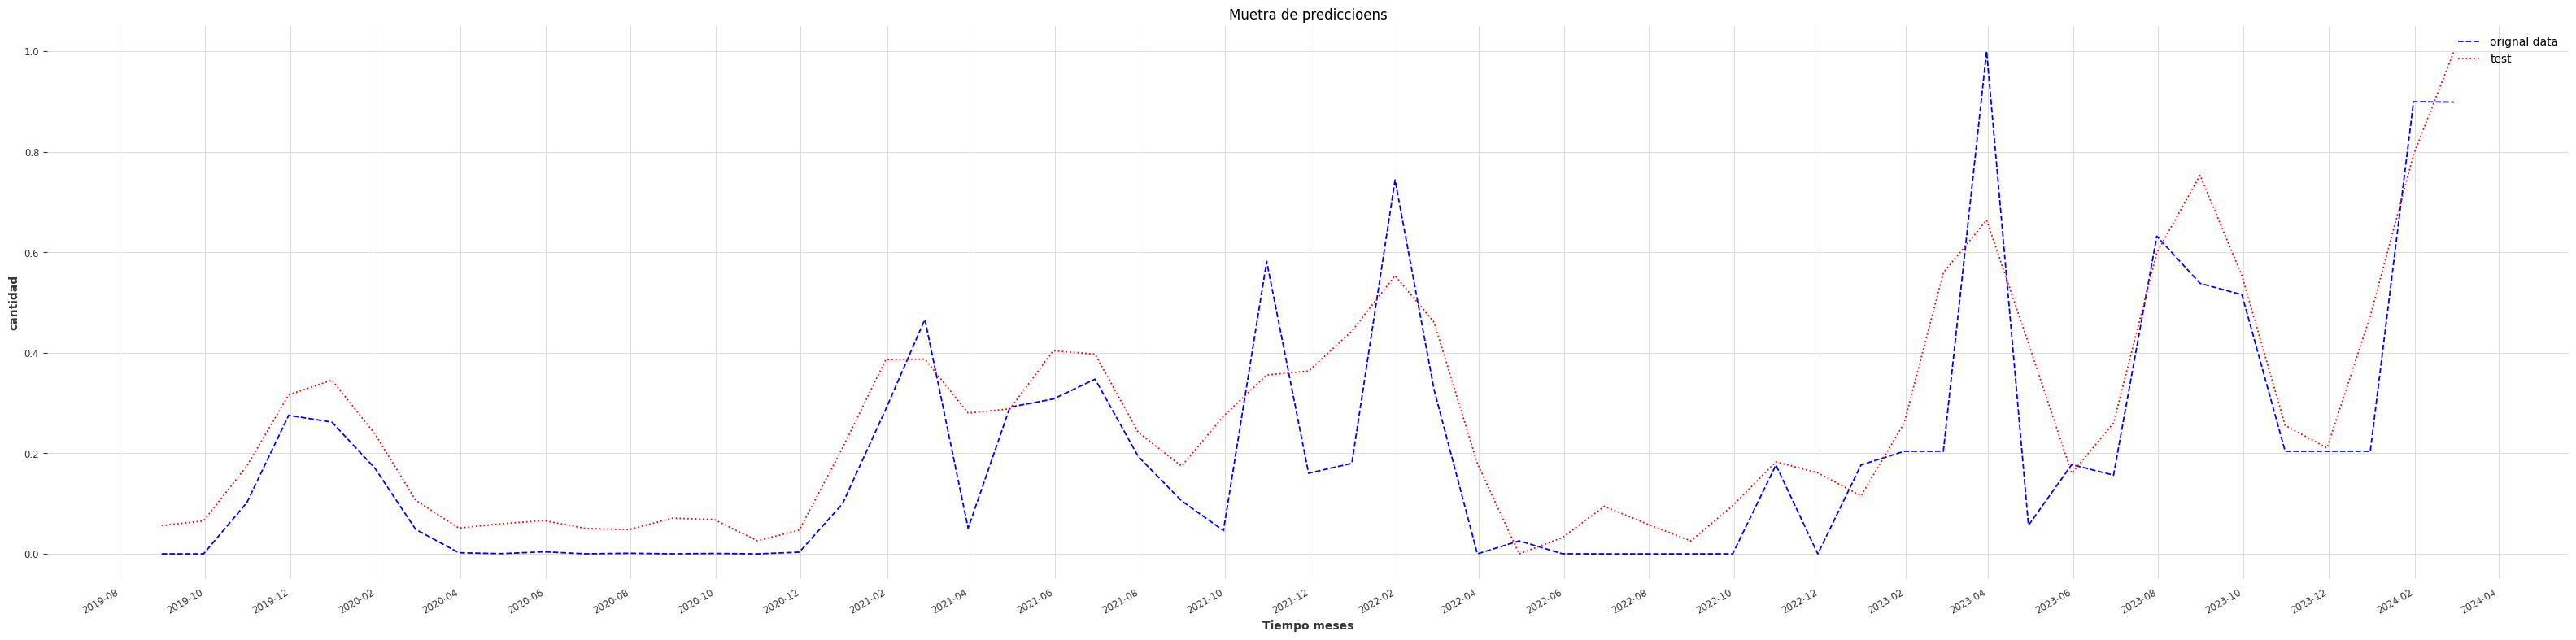

In [39]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(40, 10))


# plt.stem(outlines_data.set_index("created_at").index,
#           outlines_data['quantity'].values,
#           markerfmt='*',basefmt='--'
#           )

# plt.stem(data_frame_predicciones.set_index("time").index,
#          data_frame_predicciones['quantity'].values,
#          markerfmt='*', basefmt='--'
#          )

plt.plot(data_ready.pd_dataframe().reset_index().set_index("created_at").index,
         data_ready.pd_dataframe().reset_index()['quantity'].values,
         c='b',
         linestyle='--'
         )

plt.plot(data_ready_lp.pd_dataframe().reset_index().set_index("created_at").index,
         data_ready_lp.pd_dataframe().reset_index()['quantity'].values,
         c='r',
         linestyle= 'dotted'
         )

# plt.plot(data_frame_predicciones.set_index("time").index,
#          data_frame_predicciones['quantity'].values,
#          c='r',
#          marker='*'
#          )

# plt.plot(dataframe_pred_future.set_index("created_at").index,
#          dataframe_pred_future['quantity'].values,
#          c='g',
#          marker='o'
#          )

plt.title('Muetra de prediccioens')
plt.ylabel('cantidad')
plt.xlabel('Tiempo meses')
plt.legend(['orignal data', 'data_lowpass'])  # , loc='upper right')

fmt_half_year = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(fmt_half_year)

fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)
fig.autofmt_xdate()

plt.title('Muetra de prediccioens')
plt.ylabel('cantidad')
plt.xlabel('Tiempo meses')
plt.legend(['orignal data', 'test'], loc='upper right')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(40, 10))

data_ready_lp.pd_dataframe()
data_ready.pd_dataframe()


# plt.stem(outlines_data.set_index("created_at").index,
#           outlines_data['quantity'].values,
#           markerfmt='*',basefmt='--'
#           )

# plt.stem(data_frame_predicciones.set_index("time").index,
#          data_frame_predicciones['quantity'].values,
#          markerfmt='*', basefmt='--'
#          )

plt.plot(outlines_data.reset_index().set_index("created_at").index,
         outlines_data['quantity'].values,
         c='b',
         linestyle='--'
         )

# plt.plot(data_frame_predicciones.set_index("time").index,
#          data_frame_predicciones['quantity'].values,
#          c='r',
#          marker='*'
#          )

# plt.plot(dataframe_pred_future.set_index("created_at").index,
#          dataframe_pred_future['quantity'].values,
#          c='g',
#          marker='o'
#          )


plt.title('Muetra de prediccioens')
plt.ylabel('cantidad')
plt.xlabel('Tiempo meses')
plt.legend(['orignal data', 'test', 'validation'])  # , loc='upper right')

fmt_half_year = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(fmt_half_year)

fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)
fig.autofmt_xdate()

plt.title('Muetra de prediccioens')
plt.ylabel('cantidad')
plt.xlabel('Tiempo meses')
plt.legend(['orignal data', 'test'], loc='upper right')
plt.show()